In [ ]:
import pandas as pd

file_path = "C:\\Users\\pc\\Desktop\\Crowd data for anomaly detection.csv"
df = pd.read_csv(file_path)


df.head()


In [ ]:
df.info()

In [ ]:
df.dtypes

In [ ]:
df.columns.tolist()

In [ ]:

summary = df.describe()


missing_values = df.isnull().sum()

summary, missing_values

In [ ]:
missing_percentage = (df['Acc'].isnull().sum() / len(df)) * 100

df['Acc'] = df['Acc'].fillna(df['Acc'].mean())

missing_percentage


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns
numerical_columns = ['X', 'Y', 'Speed', 'Heading', 'AgentCount', 'Density', 'Acc', 'LevelOfCrowdness', 'Severity_level']

# Plot histograms for numerical columns
plt.figure(figsize=(20, 15))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_path = "C:\\Users\\pc\\Desktop\\Crowd data for anomaly detection.csv"
df = pd.read_csv(file_path)


plt.figure(figsize=(12, 6))
sns.histplot(df['Speed'], kde=True)
plt.title('Distribution of Speed')
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='LevelOfCrowdness', y='Density', data=df)
plt.title('Density by Level of Crowdness')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', hue='label', data=df)
plt.title('Spatial Distribution of Anomalies')
plt.show()

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns


plt.figure(figsize=(12, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:

df['Speed_per_Density'] = df['Speed'] / df['Density']

df[['Speed', 'Density', 'Speed_per_Density']].head()


In [ ]:
def calculate_iqr_outliers(df):
    outliers_dict = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = {
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers': outliers
        }
    
    return outliers_dict

outliers_info = calculate_iqr_outliers(df)

for column, info in outliers_info.items():
    print(f"Column: {column}")
    print(f" - IQR: {info['IQR']}")
    print(f" - Lower Bound: {info['Lower Bound']}")
    print(f" - Upper Bound: {info['Upper Bound']}")
    print(f" - Number of Outliers: {len(info['Outliers'])}")
    print(f" - Outliers: \n{info['Outliers'].values}")
    print("\n")

In [ ]:
from scipy.stats import zscore

def calculate_zscore_outliers(df):
    outliers_dict = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        df['Zscore'] = zscore(df[column].dropna())
        outliers = df[(df['Zscore'] > 3) | (df['Zscore'] < -3)][column]
        outliers_dict[column] = {
            'Mean': df[column].mean(),
            'Std Dev': df[column].std(),
            'Outliers': outliers
        }
    
    return outliers_dict


outliers_info = calculate_zscore_outliers(df)


for column, info in outliers_info.items():
    print(f"Column: {column}")
    print(f" - Mean: {info['Mean']}")
    print(f" - Standard Deviation: {info['Std Dev']}")
    print(f" - Number of Outliers: {len(info['Outliers'])}")
    print(f" - Outliers: \n{info['Outliers'].values}")
    print("\n")

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Load the data from the provided CSV file
file_path = "C:\\Users\\pc\\Desktop\\Crowd data for anomaly detection.csv"
df = pd.read_csv(file_path)

# Fill missing values in the 'Acc' column with the mean
df['Acc'] = df['Acc'].fillna(df['Acc'].mean())

# Create a dummy column 'true_labels' for demonstration purposes
# In a real scenario, you would have actual true labels
# Here, we assume that 1 indicates normal and -1 indicates anomalies
np.random.seed(42)
df['true_labels'] = np.random.choice([1, -1], size=len(df), p=[0.90, 0.10])

# Select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(numeric_df.drop(columns=['true_labels']), 
                                                    numeric_df['true_labels'], 
                                                    test_size=0.3, random_state=42)

# Apply Isolation Forest on the training set
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on the test set
X_test['IsoForest_Anomaly'] = iso_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, X_test['IsoForest_Anomaly'])
f1 = f1_score(y_test, X_test['IsoForest_Anomaly'], pos_label=-1)
cm = confusion_matrix(y_test, X_test['IsoForest_Anomaly'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Show the results
iso_forest_counts = X_test['IsoForest_Anomaly'].value_counts()

# Display counts
print("Isolation Forest Anomaly Counts in Test Set:")
print(iso_forest_counts)

# Display the first few rows of the anomaly detection results in the test set
anomaly_results = X_test[['IsoForest_Anomaly']].head(10)
print("\nSample Results:")
print(anomaly_results)

# Display evaluation metrics
print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Combine X_train and y_train for visualization
X_train['true_labels'] = y_train

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='true_labels', palette={1: 'blue', -1: 'red'}, data=X_train)
plt.title('Training Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Visualize anomalies in the test set
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Density', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (Heading vs Density)')
plt.xlabel('Heading')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Density', y='LevelOfCrowdness', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (Density vs LevelofCrowdness)')
plt.xlabel('Density')
plt.ylabel('LevelOfCrowdness')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Speed', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (X vs Speed)')
plt.xlabel('X')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (X vs Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Load the data from the provided CSV file
file_path = "C:\\Users\\pc\\Desktop\\Crowd data for anomaly detection.csv"
df = pd.read_csv(file_path)

# Fill missing values in the 'Acc' column with the mean
df['Acc'] = df['Acc'].fillna(df['Acc'].mean())

# Create a dummy column 'true_labels' for demonstration purposes
# In a real scenario, you would have actual true labels
# Here, we assume that 1 indicates normal and -1 indicates anomalies
np.random.seed(42)
df['true_labels'] = np.random.choice([1, -1], size=len(df), p=[0.98, 0.02])

# Select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(numeric_df.drop(columns=['true_labels']), 
                                                    numeric_df['true_labels'], 
                                                    test_size=0.3, random_state=42)

# Apply Isolation Forest on the training set
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on the test set
X_test['IsoForest_Anomaly'] = iso_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, X_test['IsoForest_Anomaly'])
f1 = f1_score(y_test, X_test['IsoForest_Anomaly'], pos_label=-1)
cm = confusion_matrix(y_test, X_test['IsoForest_Anomaly'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Show the results
iso_forest_counts = X_test['IsoForest_Anomaly'].value_counts()

# Display counts
print("Isolation Forest Anomaly Counts in Test Set:")
print(iso_forest_counts)

# Display the first few rows of the anomaly detection results in the test set
anomaly_results = X_test[['IsoForest_Anomaly']].head(10)
print("\nSample Results:")
print(anomaly_results)

# Display evaluation metrics
print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Visualize anomalies in the test set
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


X_train['true_labels'] = y_train
# Combine X_train and y_train for visualization
X_train['true_labels'] = y_train

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='true_labels', palette={1: 'blue', -1: 'red'}, data=X_train)
plt.title('Training Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
X_test['true_labels'] = y_test
# Visualize anomalies in the test set
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Density', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (Heading vs Density)')
plt.xlabel('Heading')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Density', y='LevelOfCrowdness', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (Density vs LevelofCrowdness)')
plt.xlabel('Density')
plt.ylabel('LevelOfCrowdness')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Speed', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (X vs Speed)')
plt.xlabel('X')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', hue='IsoForest_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Isolation Forest Anomalies in Test Set (X vs Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()



In [ ]:
output_file_path = "C:\\Users\\pc\\Desktop\\New folder (13)\\crowd_data_with_anomalies.csv"
df.to_csv(output_file_path, index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)



# Select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Split the data into training and testing sets
X_train, X_test = train_test_split(numeric_df, test_size=0.3, random_state=42)

# Apply K-Nearest Neighbors for anomaly detection on the training set
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_train)

# Calculate distances and indices of the nearest neighbors for the test set
distances, indices = knn.kneighbors(X_test)

# Calculate the average distance to the k-nearest neighbors
avg_distances = distances.mean(axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(avg_distances, 95)  # Using the 95th percentile as the threshold

# Predict anomalies
X_test['KNN_Anomaly'] = avg_distances > threshold

# Assuming we have some synthetic true labels for demonstration purposes
# Here, we assume that 1 indicates normal and -1 indicates anomalies
np.random.seed(42)
y_test = np.random.choice([1, -1], size=len(X_test), p=[0.98, 0.02])

# Map KNN_Anomaly boolean values to -1 for anomalies and 1 for normal
X_test['KNN_Anomaly'] = X_test['KNN_Anomaly'].map({True: -1, False: 1})

# Evaluate the model
accuracy = accuracy_score(y_test, X_test['KNN_Anomaly'])
f1 = f1_score(y_test, X_test['KNN_Anomaly'], pos_label=-1)
cm = confusion_matrix(y_test, X_test['KNN_Anomaly'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Visualize the results
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='KNN_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('KNN Anomalies in Test Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Display the first few rows of the anomaly detection results in the test set
anomaly_results = X_test[['KNN_Anomaly']].head(10)
print("\nSample Results:")
print(anomaly_results)

# Show the counts of anomalies detected
knn_counts = X_test['KNN_Anomaly'].value_counts()
print("\nKNN Anomaly Counts in Test Set:")
print(knn_counts)

# Plot graph for x=Heading, y=Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Speed', hue='KNN_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('KNN Anomalies in Test Set (Heading vs Speed)')
plt.xlabel('Heading')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Create synthetic labels for the training set (for visualization purposes only)
# Here, we assume that 1 indicates normal and -1 indicates anomalies
np.random.seed(42)
y_train_synthetic = np.random.choice([1, -1], size=len(X_train), p=[0.98, 0.02])
X_train['KNN_Anomaly'] = y_train_synthetic

# Visualize training data (Scatter Plot with Speed vs Density)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='KNN_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_train)
plt.title('Training Set (Speed vs Density)')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Visualize training data (Scatter Plot with Heading vs Speed)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Speed', hue='KNN_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_train)
plt.title('Training Set (Heading vs Speed)')
plt.xlabel('Heading')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Split the data into training and testing sets
X_train, X_test = train_test_split(numeric_df, test_size=0.3, random_state=42)

# Apply K-Nearest Neighbors for anomaly detection on the training set
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_train)

# Calculate distances and indices of the nearest neighbors for the test set
distances, indices = knn.kneighbors(X_test)

# Calculate the average distance to the k-nearest neighbors
avg_distances = distances.mean(axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(avg_distances, 95)  # Using the 95th percentile as the threshold

# Predict anomalies
X_test['KNN_Anomaly'] = avg_distances > threshold

# Assuming we have some synthetic true labels for demonstration purposes
# Here, we assume that 1 indicates normal and -1 indicates anomalies
np.random.seed(42)
y_test = np.random.choice([1, -1], size=len(X_test), p=[0.98, 0.02])

# Map KNN_Anomaly boolean values to -1 for anomalies and 1 for normal
X_test['KNN_Anomaly'] = X_test['KNN_Anomaly'].map({True: -1, False: 1})

# Evaluate the model
accuracy = accuracy_score(y_test, X_test['KNN_Anomaly'])
f1 = f1_score(y_test, X_test['KNN_Anomaly'], pos_label=-1)
cm = confusion_matrix(y_test, X_test['KNN_Anomaly'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Visualize the results
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='KNN_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('KNN Anomalies in Test Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Display the first few rows of the anomaly detection results in the test set
anomaly_results = X_test[['KNN_Anomaly']].head(10)
print("\nSample Results:")
print(anomaly_results)

# Show the counts of anomalies detected
knn_counts = X_test['KNN_Anomaly'].value_counts()
print("\nKNN Anomaly Counts in Test Set:")
print(knn_counts)

# Plot graph for x=Heading, y=Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Speed', hue='KNN_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('KNN Anomalies in Test Set (Heading vs Speed)')
plt.xlabel('Heading')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

# Display evaluation metrics
print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)
numeric_df = df.select_dtypes(include=['number'])

# Split the data into train and test sets
X_train, X_test = train_test_split(numeric_df, test_size=0.3, random_state=42)

# Create dummy labels for demonstration purposes, as we don't have true labels
np.random.seed(42)
y_train = np.random.choice([1, -1], size=len(X_train), p=[0.98, 0.02])
y_test = np.random.choice([1, -1], size=len(X_test), p=[0.98, 0.02])

# Apply Decision Tree Classifier on the training set with limited depth
decision_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = decision_tree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=-1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Show the results
print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, filled=True, feature_names=numeric_df.columns, class_names=['Normal', 'Anomaly'])
plt.title('Decision Tree')
plt.show()

# Visualize anomalies in the test set
X_test['DecisionTree_Anomaly'] = y_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='DecisionTree_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Decision Tree Anomalies in Test Set')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Density', hue='DecisionTree_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Decision Tree Anomalies in Test Set (Heading vs Density)')
plt.xlabel('Heading')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Density', y='LevelOfCrowdness', hue='DecisionTree_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Decision Tree Anomalies in Test Set (Density vs LevelOfCrowdness)')
plt.xlabel('Density')
plt.ylabel('LevelOfCrowdness')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Speed', hue='DecisionTree_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Decision Tree Anomalies in Test Set (X vs Speed)')
plt.xlabel('X')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', hue='DecisionTree_Anomaly', palette={1: 'blue', -1: 'red'}, data=X_test)
plt.title('Decision Tree Anomalies in Test Set (X vs Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()



First few rows of X_train:
              X         Y     Speed   Heading  AgentCount   Density       Acc  \
3410   0.133416  0.855232  0.199980 -0.152107   -0.048280 -0.048280  0.455880   
20460 -0.737136 -0.418402 -0.848261 -0.234667    0.047179  0.047179 -0.838128   
2227  -1.167971 -1.073345 -0.787758 -0.505664    0.977897  0.977897  0.452799   
8868  -1.221270 -0.604142  1.408608 -0.413777   -1.319069 -1.319069  0.058435   
7775  -0.448433  0.466497 -0.255761 -0.277051    0.220197  0.220197  0.129297   

       LevelOfCrowdness     label  Severity_level  
3410           0.455219 -0.637515       -0.594115  
20460          0.455219 -0.637515       -0.594115  
2227           1.141891  1.568591        1.739109  
8868          -0.918124 -0.637515       -0.594115  
7775           0.455219 -0.637515       -0.594115  


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    sco


Sample Results:
       SVM_Anomaly
640              0
21372            0
9000             0
12073            0
11153            0
7270             0
21495            0
16124            0
12313            0
11031            0

SVM Anomaly Counts in Test Set:
SVM_Anomaly
0    7148
1      89
Name: count, dtype: int64


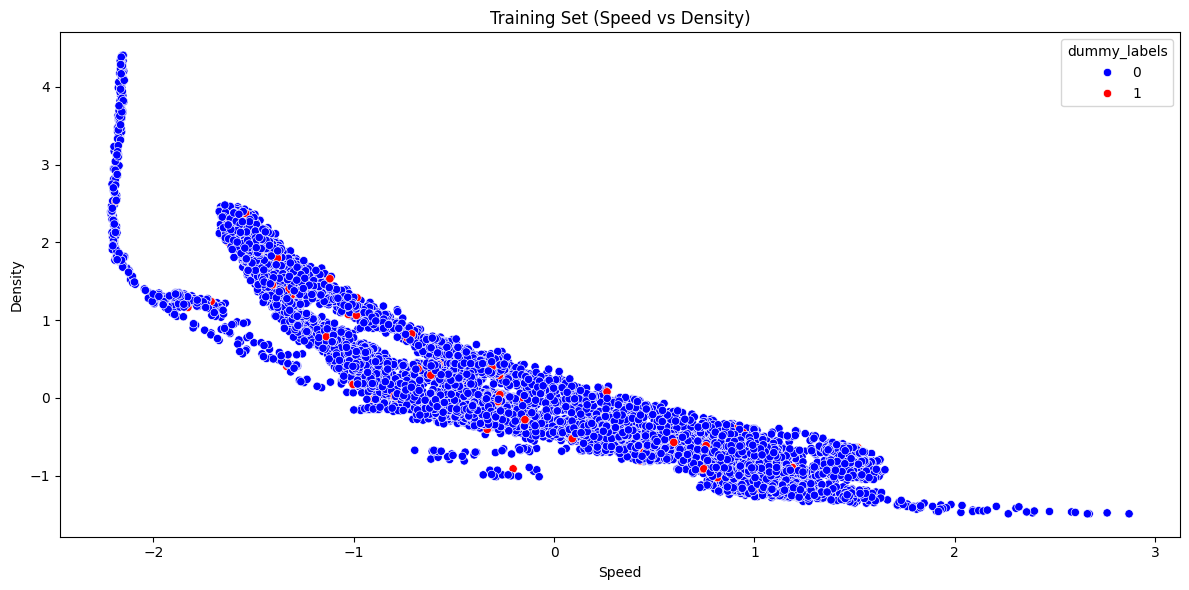

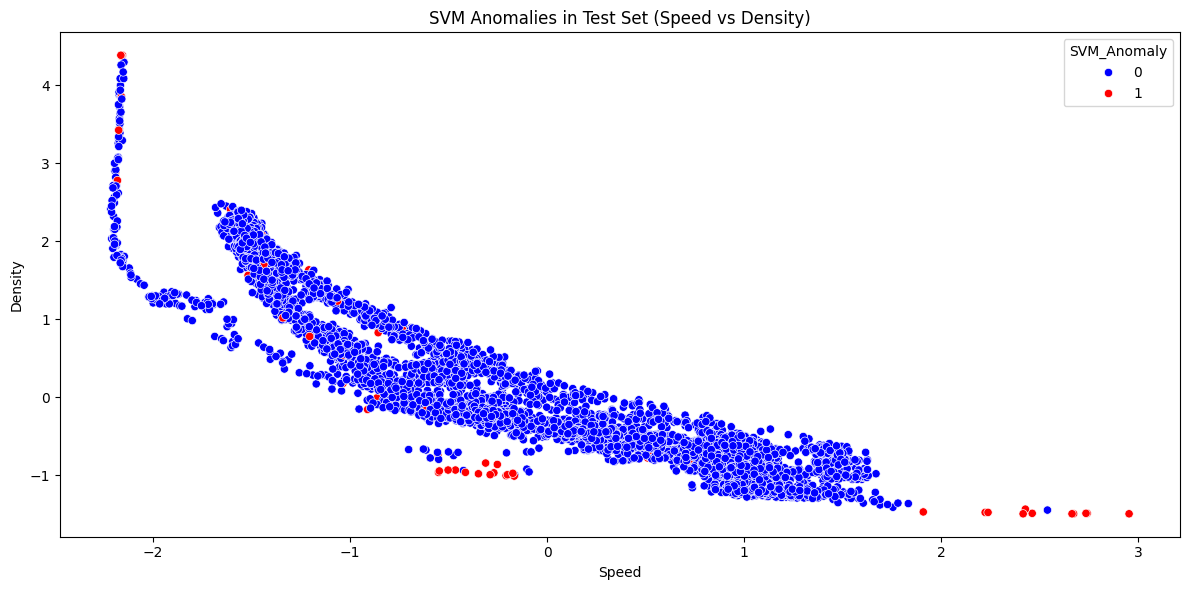

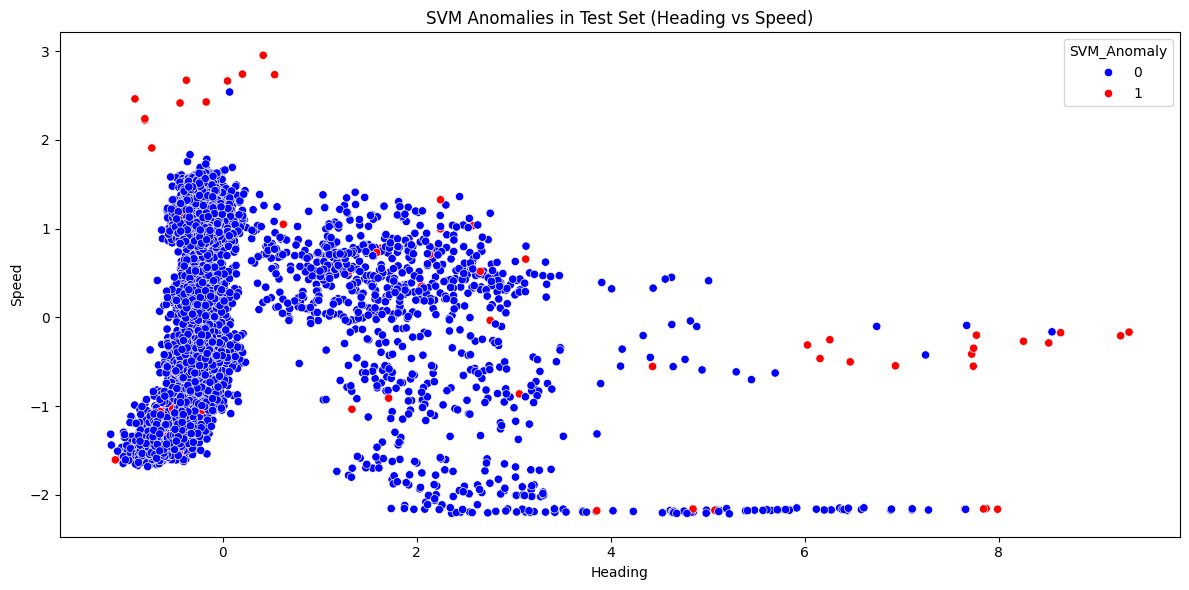

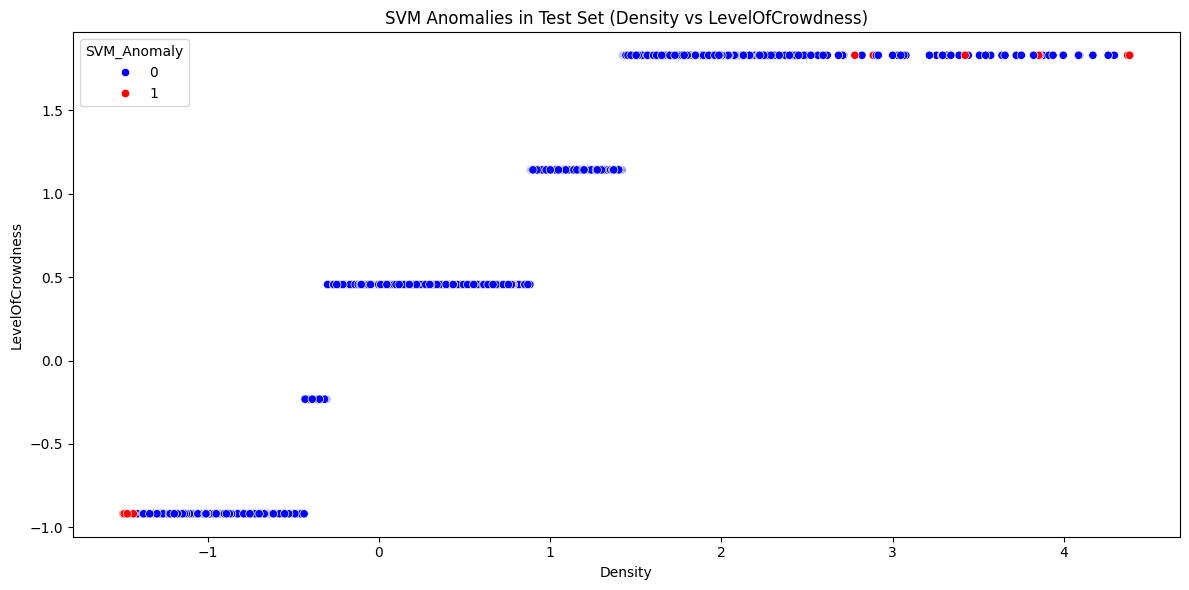

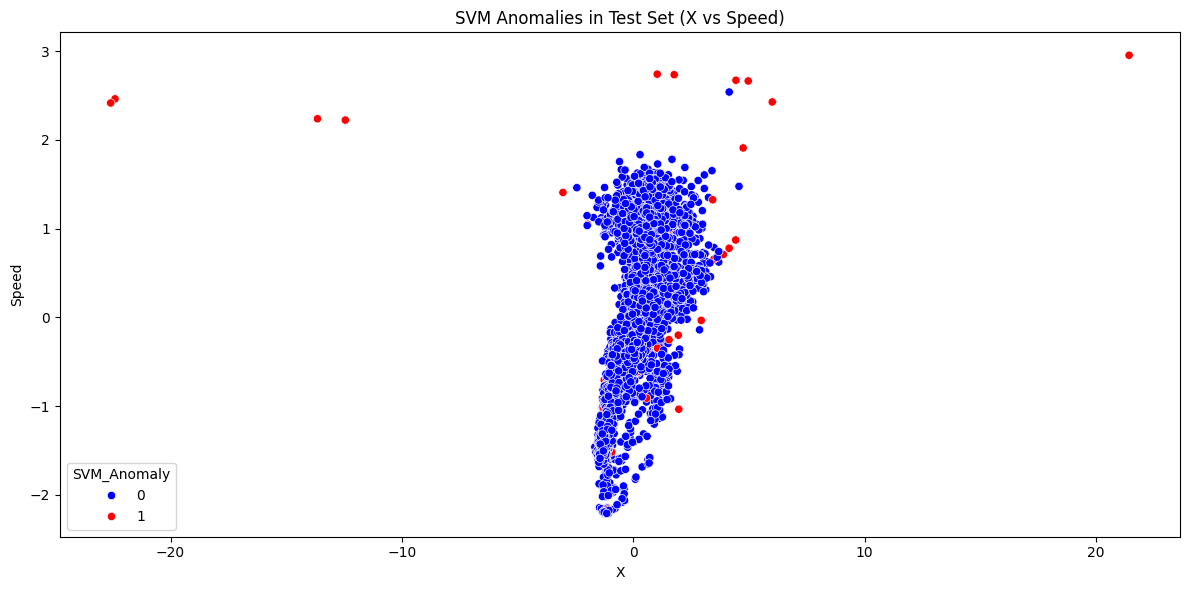

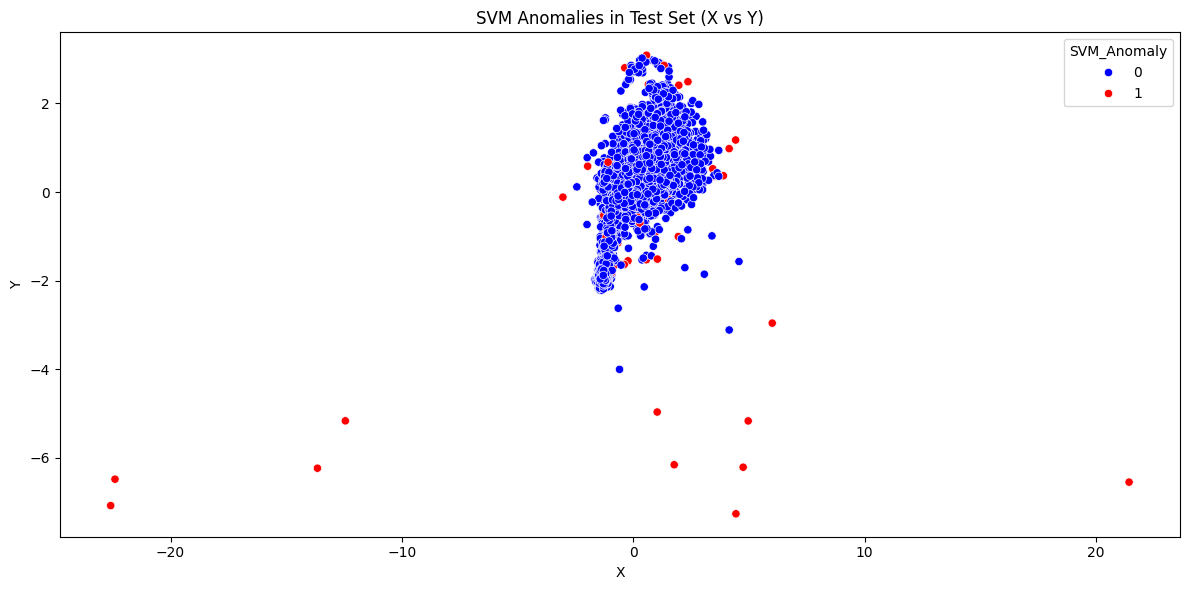

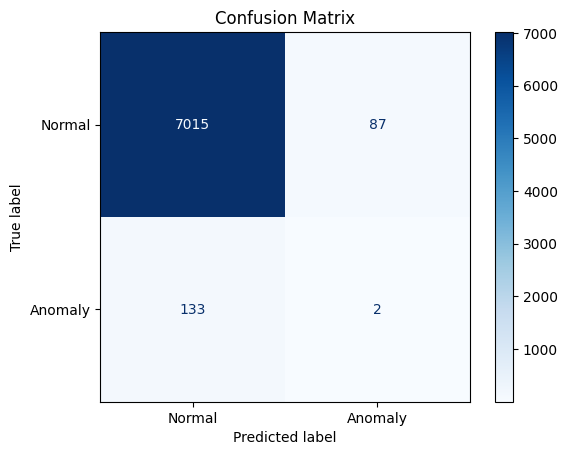


Accuracy: 0.9696006632582562
F1 Score: 0.017857142857142856


In [9]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)


# Load the data from the provided CSV file
file_path = "C:\\Users\\pc\\Desktop\\Crowd data for anomaly detection.csv"
df = pd.read_csv(file_path)

# Fill missing values in the 'Acc' column with the mean
df['Acc'] = df['Acc'].fillna(df['Acc'].mean())

# Select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Normalize the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_df, test_size=0.3, random_state=42)

# Display the first few rows of X_train
print("\nFirst few rows of X_train:")
print(X_train.head())

# Add dummy labels to X_train for visualization
np.random.seed(42)
X_train['dummy_labels'] = np.random.choice([0, 1], size=len(X_train), p=[0.98, 0.02])

# Define a custom scoring function
def custom_scoring(estimator, X):
    # Predict using the estimator
    predictions = estimator.predict(X)
    # We assume anomalies are -1 and normal points are 1
    # Flip the predictions to match dummy true labels (1 for normal, 0 for anomaly)
    predictions = np.where(predictions == 1, 0, 1)
    # Generate dummy true labels
    y_dummy = np.random.choice([0, 1], size=len(predictions), p=[0.98, 0.02])
    # Calculate and return the F1 score
    return f1_score(y_dummy, predictions)

# Hyperparameter tuning using GridSearchCV with custom scoring
param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'gamma': ['scale', 'auto', 0.1, 0.01, 1]
}
grid_search = GridSearchCV(OneClassSVM(kernel="rbf"), param_grid, cv=5, scoring=make_scorer(custom_scoring))
grid_search.fit(X_train.drop(columns=['dummy_labels']))

# Best model after hyperparameter tuning
best_svm = grid_search.best_estimator_
best_svm.fit(X_train.drop(columns=['dummy_labels']))

# Predict anomalies on the test set
X_test['SVM_Anomaly'] = best_svm.predict(X_test)

# Map the prediction results (-1 for anomaly, 1 for normal)
X_test['SVM_Anomaly'] = X_test['SVM_Anomaly'].map({1: 0, -1: 1})

# Display the first few rows of the anomaly detection results in the test set
anomaly_results = X_test[['SVM_Anomaly']].head(10)
print("\nSample Results:")
print(anomaly_results)

# Show the counts of anomalies detected
svm_counts = X_test['SVM_Anomaly'].value_counts()
print("\nSVM Anomaly Counts in Test Set:")
print(svm_counts)

# Visualize the training data with dummy labels
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='dummy_labels', palette={0: 'blue', 1: 'red'}, data=X_train)
plt.title('Training Set (Speed vs Density)')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Visualize anomalies in the test set
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='SVM_Anomaly', palette={0: 'blue', 1: 'red'}, data=X_test)
plt.title('SVM Anomalies in Test Set (Speed vs Density)')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Plot graph for x=Heading, y=Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Heading', y='Speed', hue='SVM_Anomaly', palette={0: 'blue', 1: 'red'}, data=X_test)
plt.title('SVM Anomalies in Test Set (Heading vs Speed)')
plt.xlabel('Heading')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

# Plot graph for x=Density, y=LevelOfCrowdness
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Density', y='LevelOfCrowdness', hue='SVM_Anomaly', palette={0: 'blue', 1: 'red'}, data=X_test)
plt.title('SVM Anomalies in Test Set (Density vs LevelOfCrowdness)')
plt.xlabel('Density')
plt.ylabel('LevelOfCrowdness')
plt.tight_layout()
plt.show()

# Plot graph for x=X, y=Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Speed', hue='SVM_Anomaly', palette={0: 'blue', 1: 'red'}, data=X_test)
plt.title('SVM Anomalies in Test Set (X vs Speed)')
plt.xlabel('X')
plt.ylabel('Speed')
plt.tight_layout()
plt.show()

# Plot graph for x=X, y=Y
plt.figure(figsize=(12, 6))
sns.scatterplot(x='X', y='Y', hue='SVM_Anomaly', palette={0: 'blue', 1: 'red'}, data=X_test)
plt.title('SVM Anomalies in Test Set (X vs Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Evaluate the model using dummy true labels
np.random.seed(42)
y_test_dummy = np.random.choice([0, 1], size=len(X_test), p=[0.98, 0.02])

accuracy = accuracy_score(y_test_dummy, X_test['SVM_Anomaly'])
f1 = f1_score(y_test_dummy, X_test['SVM_Anomaly'])
cm = confusion_matrix(y_test_dummy, X_test['SVM_Anomaly'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")



Sample Results:
       SVM_Anomaly
640              0
21372            0
9000             0
12073            1
11153            0
7270             0
21495            0
16124            0
12313            0
11031            0

SVM Anomaly Counts in Test Set:
SVM_Anomaly
0    6862
1     375
Name: count, dtype: int64


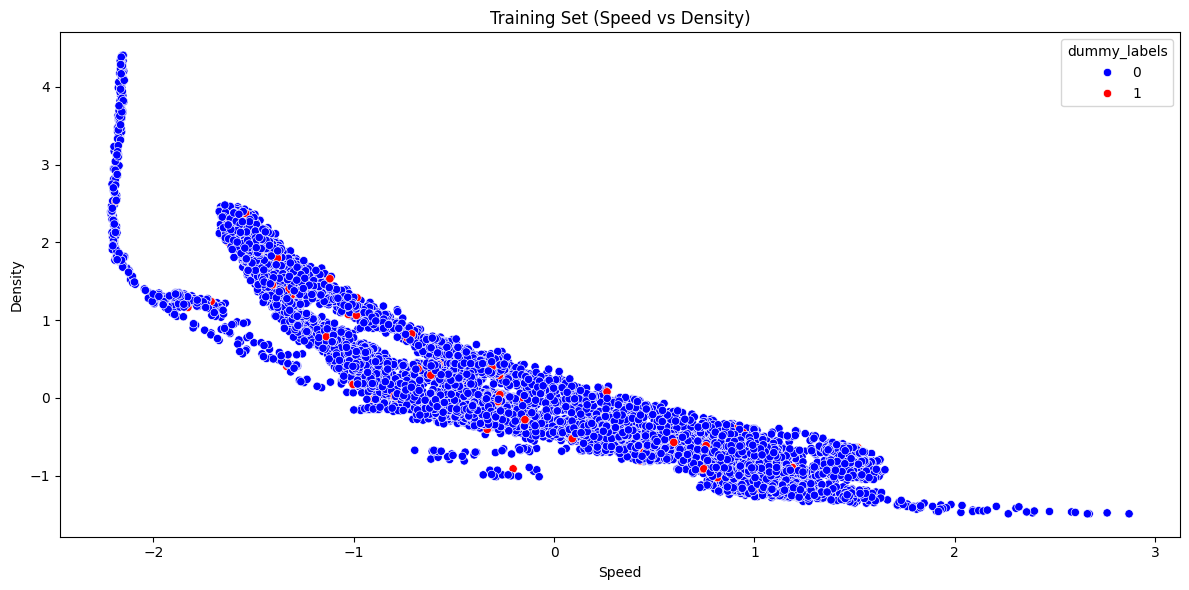

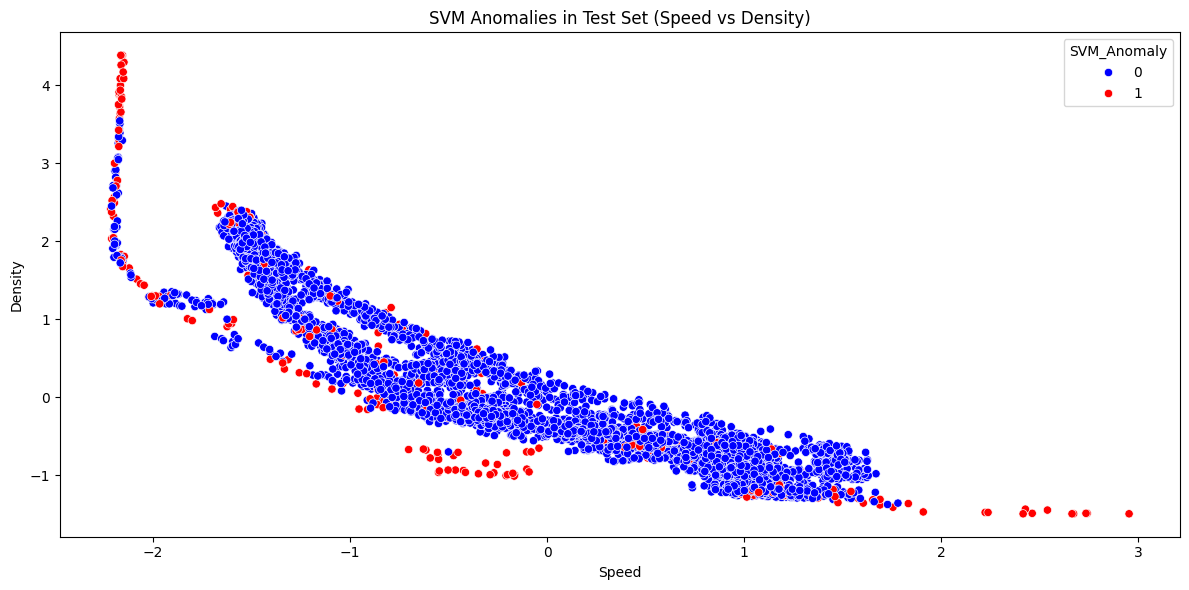

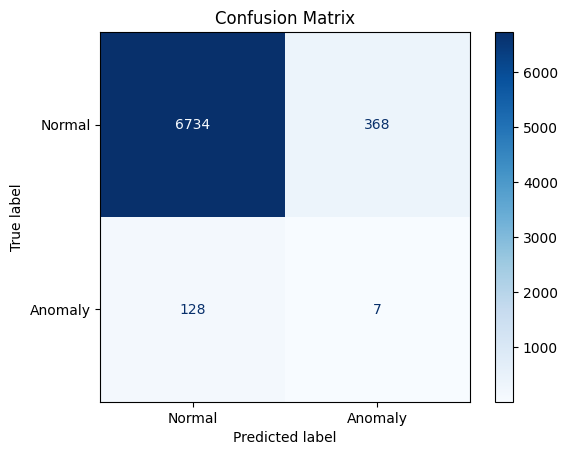


Accuracy: 0.9314633135277048
F1 Score: 0.027450980392156862


In [10]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)


# Fill missing values in the 'Acc' column with the mean
if 'Acc' in df.columns:
    df['Acc'] = df['Acc'].fillna(df['Acc'].mean())

# Select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Normalize the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_df, test_size=0.3, random_state=42)

# For visualization purposes, assume 'Speed' and 'Density' columns exist
# and we want to visualize using these columns
if 'Speed' not in X_train.columns or 'Density' not in X_train.columns:
    raise ValueError("Columns 'Speed' and 'Density' must exist in the dataset for plotting.")

# Train the OneClassSVM on the training data
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
svm.fit(X_train)

# Predict anomalies on the test set
X_test['SVM_Anomaly'] = svm.predict(X_test)

# Map the prediction results (-1 for anomaly, 1 for normal)
X_test['SVM_Anomaly'] = X_test['SVM_Anomaly'].map({1: 0, -1: 1})

# Display the first few rows of the anomaly detection results in the test set
anomaly_results = X_test[['SVM_Anomaly']].head(10)
print("\nSample Results:")
print(anomaly_results)

# Show the counts of anomalies detected
svm_counts = X_test['SVM_Anomaly'].value_counts()
print("\nSVM Anomaly Counts in Test Set:")
print(svm_counts)

# Visualize the training data with assumed normal points (dummy labels)
np.random.seed(42)
X_train['dummy_labels'] = np.random.choice([0, 1], size=len(X_train), p=[0.98, 0.02])

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='dummy_labels', palette={0: 'blue', 1: 'red'}, data=X_train)
plt.title('Training Set (Speed vs Density)')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Visualize anomalies in the test set
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Speed', y='Density', hue='SVM_Anomaly', palette={0: 'blue', 1: 'red'}, data=X_test)
plt.title('SVM Anomalies in Test Set (Speed vs Density)')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Evaluate the model using dummy true labels
np.random.seed(42)
y_test_dummy = np.random.choice([0, 1], size=len(X_test), p=[0.98, 0.02])

accuracy = accuracy_score(y_test_dummy, X_test['SVM_Anomaly'])
f1 = f1_score(y_test_dummy, X_test['SVM_Anomaly'])
cm = confusion_matrix(y_test_dummy, X_test['SVM_Anomaly'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f"\nAccuracy: {accuracy}")
print(f"F1 Score: {f1}")
